In [ ]:
import glob

In [4]:
outfile_name =  'data/data.json'

In [ ]:
with open(outfile_name, "w") as outfile:
    for infile_name in glob.glob("json/*.json"):
        with open(infile_name) as infile:
            outfile.write(infile.read().strip())
            outfile.write('\n')

In [2]:
import pandas as pd

In [5]:
df = pd.read_json(outfile_name, lines=True)

In [6]:
df.describe()

,user/throttle,user/angle,track/lap,track/loc
count,28498.000000,28498.000000,28498.000000,28498.000000
mean,0.280135,0.065209,1.994070,59.309601
std,0.074599,0.575656,1.430178,30.805851
min,0.000000,-1.000000,0.000000,0.000000
25%,0.300000,-0.277957,1.000000,33.000000
50%,0.300000,0.050961,2.000000,60.000000
75%,0.300000,0.477632,3.000000,85.000000
max,0.300000,1.000000,5.000000,113.000000


In [7]:
df['cam/image_array'] = 'images/' + df['cam/image_array']

In [8]:
import tensorflow as tf

In [9]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0  # normalize to [0,1] range
    return image

In [10]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

images/13598_cam-image_array_.jpg
(120, 160, 3)



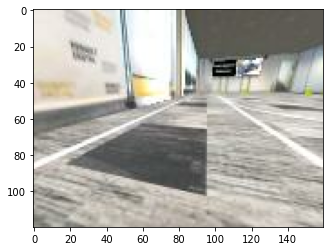

In [12]:
import matplotlib.pyplot as plt

image_path = df['cam/image_array'].values[4000]
print(image_path)
image = load_and_preprocess_image(image_path)
print(image.shape)
plt.imshow(image)
plt.grid(False)
print()

In [13]:
def get_tensors(df):
    stearing_tensor = tf.convert_to_tensor(df['user/angle'].values, dtype=tf.float32)
    
    throttle_tensor = tf.convert_to_tensor(df['user/throttle'].values, dtype=tf.float32)
    
    image_path_tensor = tf.convert_to_tensor(df['cam/image_array'].values, dtype=tf.string)
    
    return stearing_tensor, throttle_tensor, image_path_tensor

In [14]:
stearing_tensor, throttle_tensor, image_path_tensor = get_tensors(df)

In [15]:
features_dataset = tf.data.Dataset.from_tensor_slices({
    'stearing': stearing_tensor,
    'throttle': throttle_tensor,
    'image': image_path_tensor})
features_dataset

<TensorSliceDataset shapes: {stearing: (), throttle: (), image: ()}, types: {stearing: tf.float32, throttle: tf.float32, image: tf.string}>

In [16]:
def load_images(row):
    row['image'] = tf.io.read_file(row['image'])
    return row

In [17]:
features_ds = features_dataset.map(load_images)

In [18]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


In [19]:

def serialize_example(stearing, throttle, image):
    """
    Creates a tf.Example message ready to be written to a file.
    """

    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    feature = {
      'stearing': _float_feature(stearing.numpy()),
      'throttle': _float_feature(throttle.numpy()),
      'image': _bytes_feature(image.numpy())
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [21]:
def tf_serialize_example(row):
    tf_string = tf.py_function(
        serialize_example,
        (row['stearing'],row['throttle'],row['image']),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [22]:
from datetime import datetime
now = datetime.now().strftime("%Y%m%d_%H%M%S")

serialized_features_dataset = features_ds.map(tf_serialize_example)

features_tfrec = tf.data.experimental.TFRecordWriter('./data/donkey_%s.tfrec' % now)

In [23]:
features_tfrec.write(serialized_features_dataset)